## A/B-тестирование для магазина мобильной игры

Проводится а/б тест стартовых предложений в магазине мобильной игры.
Две группы:

• 1 - Контрольная

• 2 - В 5 раз снижена цена и в 2 раза наполнение стартового набора - предложения,
которое наиболее часто покупают в качестве первого платежа.

По данным в csv файле оцените эффект нововведения в тестовой группе и сформируйте
выводы.

Метрики для расчёта теста определите самостоятельно, исходя из доступного набора
данных.

Формат ответа: jupyter notebook с расчётами и выводами.

Данные для расчёта теста – в файле task2_ab_dataset.csv

### Ответ

#### Начало

Подключаем библиотеки для нашей работы

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from tqdm.notebook import tqdm

plt.style.use('ggplot')
%matplotlib inline

Дальше посмотрим на структуру наших данных

In [3]:
data_8 = pd.read_csv("task2_ab_dataset.csv")

In [4]:
data_8.head()

,user_id,ab_group,install_time,payment_time,amount
0,300647965935,1,2005-05-20 03:00:27,NaN,NaN
1,300647965937,2,2005-05-20 03:00:48,NaN,NaN
2,300647965938,2,2005-05-20 03:00:50,NaN,NaN
3,300647965942,1,2005-05-20 03:02:07,NaN,NaN
4,300647965950,2,2005-05-20 03:06:02,NaN,NaN


In [5]:
data_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83296 entries, 0 to 83295
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       83296 non-null  int64  
 1   ab_group      83296 non-null  int64  
 2   install_time  83296 non-null  object 
 3   payment_time  12262 non-null  object 
 4   amount        12262 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.2+ MB


Таким образом, поля у нас означают следующее:
- user_id - id пользователя
- ab_group - номер группы: 1 - контрольная группа, 2 - тестовая группа.
- install_time - дата и время установки приложения пользователем.
- payment_time - время покупки пользователем.
- amount - сумма, потраченная пользователем.

#### Обработка данных

Посмотрим сколько записей находятся в тестовой и контрольной группах. А также избавимся от тех пользователях (user_id), которые попали и в тестовую, и в контрольную выборки.

In [6]:
data_8["ab_group"].value_counts()

ab_group
2    41798
1    41498
Name: count, dtype: int64

In [7]:
users_groups = data_8.groupby("user_id")["ab_group"].nunique()
data_8_cleaned = data_8[~data_8["user_id"].isin(users_groups[users_groups > 1].index)]
data_8_cleaned.head()

,user_id,ab_group,install_time,payment_time,amount
0,300647965935,1,2005-05-20 03:00:27,NaN,NaN
1,300647965937,2,2005-05-20 03:00:48,NaN,NaN
2,300647965938,2,2005-05-20 03:00:50,NaN,NaN
3,300647965942,1,2005-05-20 03:02:07,NaN,NaN
4,300647965950,2,2005-05-20 03:06:02,NaN,NaN


In [8]:
data_8_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83212 entries, 0 to 83295
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       83212 non-null  int64  
 1   ab_group      83212 non-null  int64  
 2   install_time  83212 non-null  object 
 3   payment_time  12255 non-null  object 
 4   amount        12255 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


Преобразуем install_time и payment_time в тип данных для даты datetime

In [9]:
data_8_cleaned["install_time"] = pd.to_datetime(data_8_cleaned["install_time"], format = "%Y-%m-%d %H:%M:%S")
data_8_cleaned["payment_time"] = pd.to_datetime(data_8_cleaned["payment_time"], format = "%Y-%m-%d %H:%M:%S")

C:\Users\hardk\AppData\Local\Temp\ipykernel_7000\2334882959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8_cleaned["install_time"] = pd.to_datetime(data_8_cleaned["install_time"], format = "%Y-%m-%d %H:%M:%S")
C:\Users\hardk\AppData\Local\Temp\ipykernel_7000\2334882959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8_cleaned["payment_time"] = pd.to_datetime(data_8_cleaned["payment_time"], format = "%Y-%m-%d %H:%M:%S")


In [10]:
data_8_cleaned["ab_group"].value_counts()

ab_group
2    41758
1    41454
Name: count, dtype: int64

In [11]:
data_8_cleaned.install_time.value_counts()[:10]

install_time
2005-07-10 03:33:54    96
2005-05-23 16:55:48    86
2005-06-29 00:07:36    73
2005-06-27 22:31:52    70
2005-07-13 08:59:00    60
2005-05-27 03:52:53    57
2005-05-27 21:23:26    55
2005-06-01 14:59:56    55
2005-07-10 03:41:14    52
2005-06-10 08:54:50    52
Name: count, dtype: int64

In [12]:
data_8_cleaned.payment_time.value_counts()[:10]

payment_time
2005-06-17 03:42:33    2
2005-06-07 21:11:58    2
2005-06-17 09:24:29    2
2005-06-23 12:18:24    2
2005-06-23 09:36:12    2
2005-07-02 11:10:12    2
2005-06-11 00:13:00    2
2005-07-14 23:26:56    2
2005-07-03 03:06:43    2
2005-07-07 22:36:21    2
Name: count, dtype: int64

In [13]:
data_8_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83212 entries, 0 to 83295
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       83212 non-null  int64         
 1   ab_group      83212 non-null  int64         
 2   install_time  83212 non-null  datetime64[ns]
 3   payment_time  12255 non-null  datetime64[ns]
 4   amount        12255 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 3.8 MB


In [14]:
data_8_cleaned.user_id.value_counts()[:10]

user_id
304942704279    96
300647986203    86
300648258647    73
274878142668    70
304942724220    60
300648010317    57
274878106590    55
300648016330    55
304942704309    52
300648098949    52
Name: count, dtype: int64

Теперь насчёт полей payment_time и amount. Проверим, что у нас они либо одновременно равны None, либо одновременно заполнены корректным значением

In [15]:
data_8_cleaned[(data_8_cleaned.payment_time.isna() & data_8_cleaned.amount.notna()) | (data_8_cleaned.payment_time.notna() & data_8_cleaned.amount.isna())]

,user_id,ab_group,install_time,payment_time,amount


In [16]:
data_8_cleaned[data_8_cleaned.amount == 0]

,user_id,ab_group,install_time,payment_time,amount


Заполним теперь все None в amount на 0, так как None в amount означает, что пользователь ничего не приобрёл.

In [17]:
data_8_cleaned.amount = data_8_cleaned.amount.fillna(0)

C:\Users\hardk\AppData\Local\Temp\ipykernel_7000\3326867683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_8_cleaned.amount = data_8_cleaned.amount.fillna(0)


#### Анализ данных

Наконец-то составим контрольную и тестовую выборки.

In [18]:
control_group = data_8_cleaned[data_8_cleaned.ab_group == 1]
test_group = data_8_cleaned[data_8_cleaned.ab_group == 2]

In [19]:
control_group.shape, test_group.shape

((41454, 5), (41758, 5))

Добавим столбец даты установки, а не даты и времени установки, чтобы посчитать выручку по дням.

In [20]:
control_group = control_group.assign(install_date = lambda x : x.install_time.dt.date)
test_group = test_group.assign(install_date = lambda x : x.install_time.dt.date)

In [21]:
control_group.amount.value_counts(), test_group.amount.value_counts()

(amount
 0.0        35303
 499.0       4002
 1999.0       781
 999.0        721
 4999.0       325
 9999.0       190
 24999.0      132
 Name: count, dtype: int64,
 amount
 0.0        35654
 499.0       3300
 100.0        870
 1999.0       741
 999.0        689
 4999.0       309
 9999.0       123
 24999.0       72
 Name: count, dtype: int64)

In [22]:
control_amount = control_group.groupby("install_date")["amount"].sum()
test_amount = test_group.groupby("install_date")["amount"].sum()

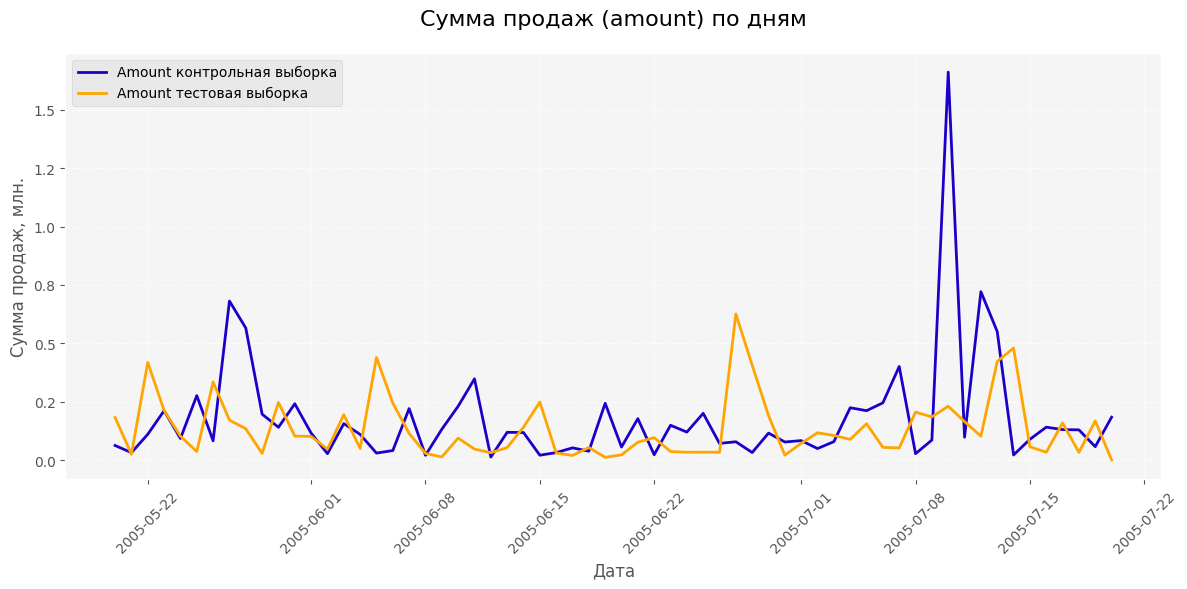

In [25]:
from datetime import datetime

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(control_amount.index, control_amount.values, color='#1b00c9', linewidth=2, label='Amount контрольная выборка')
plt.plot(test_amount.index, test_amount.values, color='orange', linewidth=2, label='Amount тестовая выборка')

plt.title('Сумма продаж (amount) по дням', fontsize=16, pad=20)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма продаж, млн.', fontsize=12)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f5f5f5')

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()

plt.show()

По сумме продаж можно заметить некоторые выбросы в обеих выборках, но в целом распределения похожи. 

Посмотрим на основные статистические характеристики тестовой и контрольной выборок.

In [27]:
control_amount.describe()

count    6.200000e+01
mean     1.790782e+05
std      2.441246e+05
min      1.397600e+04
25%      5.730350e+04
50%      1.164145e+05
75%      2.094825e+05
max      1.660107e+06
Name: amount, dtype: float64

In [28]:
test_amount.describe()

count        62.000000
mean     136738.161290
std      133476.149398
min        1996.000000
25%       35633.000000
50%       99745.000000
75%      185042.750000
max      626097.000000
Name: amount, dtype: float64

Значимых проблем не видно, поэтому перейдём к тестированию.

#### Тесты

##### Тест конверсии

Для начала проверим гипотезу о равенстве конверсий теста и контроля, где конверсией мы называем отношение количества совершённых покупок к количеству всех установок.

$H_0: \hat{p_1} = \hat{p_2}$

$H_1: \hat{p_1} \neq \hat{p_2}$

Где $p_1, p_2$ - истинные конверсии в контрольной и тестовой выборках.
Причём, если двусторонняя гипотеза $H_0$ будет отвергнута, то мы проверим гипотезы на больше и меньше

Для начала напишем функцию, которая будет проводить z-тест для сравнения средних двух выборок, а также он будет выдавать доверительный интервал для разности средних (если интервал содержит 0, то принимаем гипотезу $H_0$)

In [127]:
from scipy import stats
import numpy as np

def cr_test(ma, na, mb, nb, alpha, alternative="two-sided"):
    '''
    output:
    False - H_0 принимается 
    True - H_0 отвергается 
    '''
    wa = ma / na
    wb = mb / nb
    w = (ma + mb) / (na + nb)
    diff = wb - wa
    stat = (diff) / np.sqrt(w * (1 - w) * (1. / na + 1. / nb))
    # 
    dist_norm = stats.norm(loc=0, scale=1)
    # 
    SE = np.sqrt(w * (1-w) * (1/na + 1/nb))
    quantile = dist_norm.ppf(alpha/2)
    CI = (diff + SE * quantile, diff - SE * quantile)
    # 
    if alternative == "two-sided":
        p_value = 2 * min(dist_norm.sf(stat), dist_norm.cdf(stat))
        if p_value > alpha:
            return False, CI
        return True, CI
    elif alternative == "greater":
        p_value = dist_norm.sf(stat)
        if p_value > alpha:
            return False, CI
        return True, CI
    elif alternative == "less":
        p_value = dist_norm.cdf(stat)
        if p_value > alpha:
            return False, CI
        return True, CI
    return None, CI

Составим выборки. Так как есть множество пользователей, которые платили по нескольку раз, следовательно необходимо посчитать более корректно числитель конверсии

In [128]:
ma = (control_group.groupby("user_id").amount.sum() > 0).sum()
na = (control_group.groupby("user_id").amount.sum()).count()
# 
mb = (test_group.groupby("user_id").amount.sum() > 0).sum()
nb = (test_group.groupby("user_id").amount.sum()).count()
ma, na, mb, nb

(np.int64(851), np.int64(36148), np.int64(1013), np.int64(36665))

In [129]:
print(f"размер контроля = {na} и количество покупок = {ma}")
print(f"размер контроля = {nb} и количество покупок = {mb}")

размер контроля = 36148 и количество покупок = 851
размер контроля = 36665 и количество покупок = 1013


In [152]:
ma / na, mb / nb

(np.float64(0.02354210468075689), np.float64(0.02762852856948043))

Проводим сам тест

In [130]:
alpha = .05
cr_test_two_sided, CI = cr_test(ma, na, mb, nb, alpha)
print(f"доверительный интервал для разности средних = {CI}")
if cr_test_two_sided:
    print(f"Принимаем H_1 : p_1 != p_2")
else:
    print(f"Принимаем H_0 : p_1 = p_2")
if cr_test_two_sided:
    cr_test_greater, CI = cr_test(ma, na, mb, nb, alpha, "greater")
    if cr_test_greater:
        print(f"Принимаем H_1 : p_1 > p_2")
    else:
        print(f"Принимаем H_0")
    # 
    cr_test_less, CI = cr_test(ma, na, mb, nb, alpha, "less")
    if cr_test_less:
        print(f"Принимаем H_1 : p_1 < p_2")
    else:
        print(f"Принимаем H_0")

доверительный интервал для разности средних = (np.float64(0.0017920101189824217), np.float64(0.006380837658464662))
Принимаем H_1 : p_1 != p_2
Принимаем H_1 : p_1 > p_2
Принимаем H_0


Таким образом, мы получили, что в результате A/B-тесторования конверсия для тестовой выборки увеличилась.

##### Тест среднего чека

Теперь давайте сравним математические ожидания трат в тестовой и контрольной выборках. То есть проверим гипотезы:

$H_0: E(Y) = E(X)$

$H_1: E(Y) \neq E(X) $

Где X, Y - это случайные величины, показывающие сколько пользователь потратил в приложении для контрольной, тестовой выборок, в которой мы оставили только платящих пользователей.
Причём, если двусторонняя гипотеза $H_0$ будет отвергнута, то мы проверим гипотезы на больше и меньше.

Мы будем проводить t-тест. Нижи написана функция, которая проводит t-тест для разных альтернатив.

In [131]:
from scipy.stats import ttest_ind

def aov_ttest(a, b, alpha, alternative="two-sided", equal_var=True):
    '''
    output:
    False - H_0 принимается 
    True - H_0 отвергается 
    '''
    ret = ttest_ind(a, b, alternative = alternative, equal_var=equal_var)
    return (False if ret.pvalue > alpha else True)

In [132]:
control_group_pay = control_group[control_group.amount > 0].amount
test_group_pay = test_group[test_group.amount > 0].amount

In [133]:
control_group_pay.shape, test_group_pay.shape

((6151,), (6104,))

Проведём тест Шапиро–Уилка для проверки нормальности выборок.

In [134]:
stats.shapiro(control_group_pay), stats.shapiro(test_group_pay)

C:\Users\hardk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6151.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\hardk\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6104.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=np.float64(0.3574136676641625), pvalue=np.float64(6.096813155179393e-91)),
 ShapiroResult(statistic=np.float64(0.3533063654683626), pvalue=np.float64(6.841146937421494e-91)))

Можно сделать вывод, что выборки распределены не нормально. Оно и понятно, так как обычно траты распределены экспоненциально или логнормально.

Тем не менее ранее мы увидели, что выборки достаточно большие, чтобы t-тест смог сработать и для выборок, распределённых не по нормальному закону.

Теперь проведём тест Левена, чтобы проверить, что выборки имеют одинаковые дисперсии, что поможет нам при проведении t-теста. 

In [135]:
stats.levene(control_group_pay, test_group_pay)

LeveneResult(statistic=np.float64(22.765587659538028), pvalue=np.float64(1.8512569654603518e-06))

Из того, что pvalue меньше чем $\alpha = 5\%$, можно сделать вывод, что дисперсии теста и контроля различаются. 

Учтём это в t-тесте, который идёт следующим

In [153]:
alpha = .05
ret_two_side = aov_ttest(control_group_pay, test_group_pay, alpha, equal_var=False)
if ret_two_side:
    print(f"Принимаем H_1 : E(Y) != E(X)")
else:
    print(f"Принимаем H_0 : E(Y) == E(X)")
if ret_two_side:
    ret_greater = aov_ttest(control_group_pay, test_group_pay, alpha, "greater", equal_var=False)
    if ret_greater:
        print(f"Принимаем H_1 : E(Y) > E(X)")
    else:
        print(f"Принимаем H_0")

Принимаем H_1 : E(Y) != E(X)
Принимаем H_1 : E(Y) > E(X)


Таким образом, мы получаем статистически значимый результат, что выручка от пользователей в среднем в тесте увеличилась. Посмотрим на доверительный интервал разницы в t-тесте.

In [137]:
import numpy as np
import statsmodels.stats.api as sms

cm = sms.CompareMeans(sms.DescrStatsW(control_group_pay), sms.DescrStatsW(test_group_pay))
print(f"доверительный интервал = {cm.tconfint_diff(usevar='unequal')}")

доверительный интервал = (np.float64(291.4923832235467), np.float64(540.8292922469678))


Таким образом, увеличение среднего чека для теста лежит в доверительном интервале от 291.49 до 540.83.

Также t-тест (даже с большим количество характеристик) можно было провести с помощью такого классного инструмента, как pingouin - это открытый статистический пакет на Python, предоставляющий широкий спектр функций для статистического анализа. 

In [138]:
import pingouin as pg

res = pg.ttest(control_group_pay, test_group_pay, correction=False)
print(res)

               T    dof alternative         p-val             CI95%   cohen-d  \
T-test  6.537357  12253   two-sided  6.509929e-11  [291.38, 540.94]  0.118108   

             BF10     power  
T-test  3.648e+07  0.999998  


In [139]:
print(f"p_value = {res['p-val'].iloc[0]}")
print(f"Доверительный интервал = {res["CI95%"].iloc[0]}")
print(f"Мощность = {res["power"].iloc[0]}")
print(f"Effect size = {res["cohen-d"].iloc[0]}")

p_value = 6.50992909391611e-11
Доверительный интервал = [291.38 540.94]
Мощность = 0.9999976401987042
Effect size = 0.11810784564596336


##### Тест ARPU

Теперь было бы интересно провести тест для ARPU, так как он в отличие от среднего чека в ARPU учитывается сегмент не платящих пользователей.
Известно, что ARPU = средний чек * конверсия. Так что по идее ARPU тоже должен увеличиться

In [140]:
control_group_arpu = control_group.amount
test_group_arpu = test_group.amount

In [141]:
stats.levene(control_group_arpu, test_group_arpu)

LeveneResult(statistic=np.float64(40.5675640709559), pvalue=np.float64(1.9092071671643656e-10))

In [154]:
alpha = .05
ret_two_side = aov_ttest(control_group_arpu, test_group_arpu, alpha, equal_var=False)
if ret_two_side:
    print(f"Принимаем H_1 : E(Y) != E(X)")
else:
    print(f"Принимаем H_0 : E(Y) == E(X)")
if ret_two_side:
    ret_greater = aov_ttest(control_group_arpu, test_group_arpu, alpha, "greater", equal_var=False)
    if ret_greater:
        print(f"Принимаем H_1 : E(Y) > E(X)")
    else:
        print(f"Принимаем H_0")

Принимаем H_1 : E(Y) != E(X)
Принимаем H_1 : E(Y) > E(X)


In [145]:
cm = sms.CompareMeans(sms.DescrStatsW(control_group_arpu), sms.DescrStatsW(test_group_arpu))
print(f"Доверительный интервал = {cm.tconfint_diff(usevar='unequal')}")

Доверительный интервал = (np.float64(44.85100296610179), np.float64(84.7770905253632))


Таким образом, мы получаем статистически значимый результат, что ARPU в тесте увеличился. При этом увеличение ARPU для теста лежит в доверительном интервале от 44 до 84.

#### Выводы

Таким образом, мы получили, что:
- Конверсия выросла с 2.35% до 2.76% (на 0.18–0.64%). Снижение цены в 5 раз сделало стартовый набор более привлекательным.
- Средний чек вырос с 1,805 до 2,221 (на 291–541 единиц). Хотя цена стартового набора упала, пользователи в тесте совершали больше дополнительных покупок, что увеличило общий средний чек.
- ARPU вырос с 307 до 369 (на 44.85–84.78 единиц). Рост конверсии и среднего чека привел к увеличению дохода на пользователя.

Итак, нам необходимо внедрять новое предложение: Дешевый стартовый набор увеличил конверсию и подтолкнул пользователей к дополнительным тратам, что привело к росту ARPU и общей выручки.
Тем не менее в дальнейшем в любом случае необходимо проверить retention rate, так как вдруг своим решением мы на ранней стадии мы привлекли пользователей, а на поздней им будет скучнее играть. А также соответственно нужно будет посчитать LTV (Life Time Value).